In [7]:
import os
os.chdir(r"C:\Users\Negar\Desktop\paper_results\Myself\cr_coad_project")
import pandas as pd
from pathlib import Path

clinical = pd.read_csv("data/processed/clinical/clinical_features_with_id.csv")
print("Total clinical patients:", len(clinical))
print("Patients with series_id:", clinical['series_id'].notna().sum())
print("Patients missing series_id:", clinical['series_id'].isna().sum())

missing = clinical[clinical['series_id'].isna()]
print("\nPatients missing series_id:\n", missing.head(10))



Total clinical patients: 633
Patients with series_id: 23
Patients missing series_id: 610

Patients missing series_id:
     gender age_at_diagnosis  tumor_stage  metastasis_status series_id
23     1.0            30194          3.0                  0       NaN
24     0.0            27771          2.0                  0       NaN
25     0.0            19802          2.0                  0       NaN
26     0.0            21670          2.0                  0       NaN
27     0.0            24865          2.0                  0       NaN
28     0.0            18334          2.0                  0       NaN
29     0.0            23644          2.0                  0       NaN
30     0.0            21792          1.0                  0       NaN
31     0.0            12113          2.0                  0       NaN
32     0.0            29189          2.0                  0       NaN


In [5]:
# 06_train_image_model.ipynb
# --------------------------------------------------
import os
os.chdir(r"C:\Users\Negar\Desktop\paper_results\Myself\cr_coad_project")
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from tensorflow.keras.metrics import AUC, Precision, Recall

# Force TensorFlow to use CPU if no GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("TensorFlow:", tf.__version__)
print("GPU devices:", tf.config.list_physical_devices('GPU'))

BATCH_SIZE = 16          # moderate, safe for CPU = 8
EPOCHS = 8              # short but meaningful = 5; GPU run will use 8–10

DATA_DIR = Path("data/processed/images/all_slices")
INDEX = Path("data/processed/images/all_index.csv")
SPLIT_DIR = Path("data/splits")
IMG_SIZE = (224, 224)


print("TensorFlow:", tf.__version__)
df = pd.read_csv(INDEX)
print("Total samples:", len(df))

# Load split IDs
train_ids = pd.read_csv(SPLIT_DIR / "train_series.csv")["series_id"].tolist()
val_ids   = pd.read_csv(SPLIT_DIR / "val_series.csv")["series_id"].tolist()
test_ids  = pd.read_csv(SPLIT_DIR / "test_series.csv")["series_id"].tolist()

# Attach split info
def assign_split(row):
    sid = row["series_id"]
    if sid in train_ids: return "train"
    if sid in val_ids:   return "val"
    if sid in test_ids:  return "test"
    return "ignore"

df["split"] = df.apply(assign_split, axis=1)
df = df[df["split"] != "ignore"]
print(df["split"].value_counts())

# --------------------Matching Labels--------------------------
# Assign metastasis labels from clinical data
clinical_path = Path("data/processed/clinical/clinical_features_with_id.csv")
if clinical_path.exists():
    clinical_df = pd.read_csv(clinical_path)[["patient_id", "metastasis_status"]]
    merged_df = df.merge(clinical_df, on="patient_id", how="left")
    
    # Clean metastasis_status into numeric labels
    merged_df["metastasis_status"] = merged_df["metastasis_status"].str.lower()
    merged_df["label"] = merged_df["metastasis_status"].map({
        "metastatic": 1,
        "yes": 1,
        "positive": 1,
        "non-metastatic": 0,
        "no": 0,
        "negative": 0
    })
    
    # Fill unknowns (if any) with 0 for now
    merged_df["label"] = merged_df["label"].fillna(0).astype(int)
    
    df = merged_df
    print(f"✅ Labels assigned from clinical data ({df['label'].sum()} metastatic, {len(df)-df['label'].sum()} non-metastatic).")
else:
    print("⚠️ Clinical file not found. Using temporary random labels.")
    np.random.seed(42)
    df["label"] = np.random.randint(0, 2, len(df))


# --------------------------------------------------
# DATA PIPELINE
def decode_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def make_dataset(subdf, augment=False):
    path_col = "slice_path" if "slice_path" in subdf.columns else "rep_slice"
    paths = subdf[path_col].astype(str).tolist()
    labels = subdf["label"].astype(int).tolist()
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(lambda p, y: (decode_img(p), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
    return ds.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(df[df.split=="train"], augment=True)
val_ds   = make_dataset(df[df.split=="val"])
test_ds  = make_dataset(df[df.split=="test"])

# --------------------------------------------------
# MODEL
base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=IMG_SIZE + (3,),
    weights="imagenet",
    pooling="avg"
)
base.trainable = False

model = tf.keras.Sequential([
    base,
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        Precision(name="precision"),
        Recall(name="recall"),
        AUC(name="auc")
    ]
)

model.summary()

# --------------------------------------------------
# TRAIN
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# --------------------------------------------------
# CLEAN SAVE (avoid EagerTensor serialization)
import shutil
save_dir = Path("results/images/baseline_image_model_clean_tf")
shutil.rmtree(save_dir, ignore_errors=True)
save_dir.parent.mkdir(parents=True, exist_ok=True)

# Save using the TensorFlow SavedModel format (NOT .keras)
tf.saved_model.save(model, str(save_dir))
print("✅ Model saved successfully (TensorFlow SavedModel format).")

# model = tf.saved_model.load("results/images/baseline_image_model_clean_tf")

# --------------------------------------------------
# EVALUATE
results = model.evaluate(test_ds, return_dict=True)
print("Test metrics:", results)

# --------------------------------------------------
# SAVE WEIGHTS & HISTORY
Path("results/images").mkdir(parents=True, exist_ok=True)
model.save_weights("results/images/baseline_image_weights_only.h5")

pd.DataFrame(history.history).to_csv("results/images/training_history.csv", index=False)
print("✅ Model weights + training history saved safely (no JSON serialization).")

# --------------------------------------------------
# PLOT TRAINING CURVES
plt.figure(figsize=(8, 4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy")
plt.show()

TensorFlow: 2.12.0
GPU devices: []
TensorFlow: 2.12.0
Total samples: 27822
split
train    19603
test      4166
val       4053
Name: count, dtype: int64


KeyError: "['patient_id'] not in index"

TensorFlow: 2.12.0
Total samples: 23
split
train    18
test      3
val       2
Name: count, dtype: int64
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dropout_15 (Dropout)        (None, 1280)              0         
                                                                 
 dense_15 (Dense)            (None, 1)                 1281      
                                                                 
Total params: 4,050,852
Trainable params: 1,281
Non-trainable params: 4,049,571
_________________________________________________________________
Epoch 1/8
2/2 [==============================] - 11s 2s/step - loss: 0.7215 - accuracy: 0.4444 - precision: 1.0000 - recall: 0.0909 - auc: 0.6169 - val_loss: 0.6976 - val_accuracy: 0.5000 - val_prec

INFO:tensorflow:Assets written to: results\images\baseline_image_model_clean_tf\assets


INFO:tensorflow:Assets written to: results\images\baseline_image_model_clean_tf\assets


✅ Model saved successfully (TensorFlow SavedModel format).
1/1 [==============================] - 0s 293ms/step - loss: 0.6275 - accuracy: 1.0000 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.0000e+00
Test metrics: {'loss': 0.6274771690368652, 'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0, 'auc': 0.0}
✅ Model weights + training history saved safely (no JSON serialization).


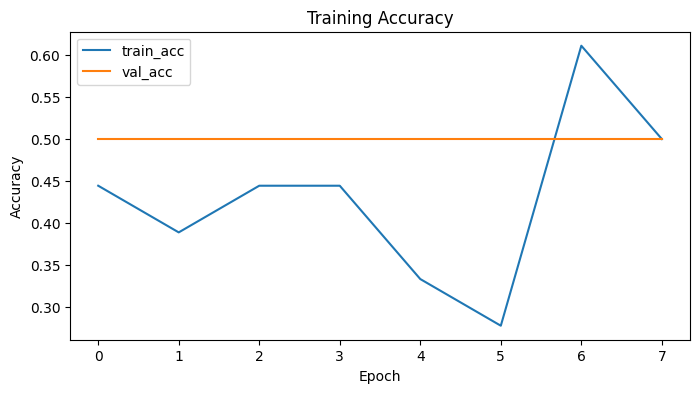

In [ ]:
# # 06_train_image_model.ipynb
# # --------------------------------------------------
# import os
# os.chdir(r"C:\Users\Negar\Desktop\paper_results\Myself\cr_coad_project")
# import tensorflow as tf
# import matplotlib.pyplot as plt
# import pandas as pd
# import numpy as np
# from pathlib import Path
# from tensorflow.keras.metrics import AUC, Precision, Recall

# # --------------------------------------------------
# # CONFIG
# DATA_DIR = Path("data/processed/images/rep_slices")
# INDEX = Path("data/processed/images/rep_index.csv")
# SPLIT_DIR = Path("data/splits")
# BATCH_SIZE = 16
# IMG_SIZE = (224, 224)
# EPOCHS = 8
# # --------------------------------------------------

# print("TensorFlow:", tf.__version__)
# df = pd.read_csv(INDEX)
# print("Total samples:", len(df))

# # Load split IDs
# train_ids = pd.read_csv(SPLIT_DIR / "train_series.csv")["series_id"].tolist()
# val_ids   = pd.read_csv(SPLIT_DIR / "val_series.csv")["series_id"].tolist()
# test_ids  = pd.read_csv(SPLIT_DIR / "test_series.csv")["series_id"].tolist()

# # Attach split info
# def assign_split(row):
#     sid = row["series_id"]
#     if sid in train_ids: return "train"
#     if sid in val_ids:   return "val"
#     if sid in test_ids:  return "test"
#     return "ignore"

# df["split"] = df.apply(assign_split, axis=1)
# df = df[df["split"] != "ignore"]
# print(df["split"].value_counts())

# # Label: 0 = non-metastatic, 1 = metastatic (temporary simulation)
# # Later this will come from metastasis_status in patients_master.csv
# df["label"] = np.where(np.arange(len(df)) % 2 == 0, 1, 0)

# # --------------------------------------------------
# # DATA PIPELINE
# def decode_img(path):
#     img = tf.io.read_file(path)
#     img = tf.image.decode_png(img, channels=3)
#     img = tf.image.resize(img, IMG_SIZE)
#     img = tf.cast(img, tf.float32) / 255.0
#     return img

# def make_dataset(subdf, augment=False):
#     paths = subdf["rep_slice"].astype(str).tolist()
#     labels = subdf["label"].astype(int).tolist()
#     ds = tf.data.Dataset.from_tensor_slices((paths, labels))
#     ds = ds.map(lambda p, y: (decode_img(p), y),
#                 num_parallel_calls=tf.data.AUTOTUNE)
#     if augment:
#         ds = ds.map(lambda x, y: (tf.image.random_flip_left_right(x), y))
#     return ds.shuffle(100).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# train_ds = make_dataset(df[df.split=="train"], augment=True)
# val_ds   = make_dataset(df[df.split=="val"])
# test_ds  = make_dataset(df[df.split=="test"])

# # --------------------------------------------------
# # MODEL
# base = tf.keras.applications.EfficientNetB0(
#     include_top=False,
#     input_shape=IMG_SIZE + (3,),
#     weights="imagenet",
#     pooling="avg"
# )
# base.trainable = False

# model = tf.keras.Sequential([
#     base,
#     tf.keras.layers.Dropout(0.3),
#     tf.keras.layers.Dense(1, activation="sigmoid")
# ])

# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-4),
#     loss="binary_crossentropy",
#     metrics=[
#         "accuracy",
#         Precision(name="precision"),
#         Recall(name="recall"),
#         AUC(name="auc")
#     ]
# )

# model.summary()

# # --------------------------------------------------
# # TRAIN
# history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# # --------------------------------------------------
# # CLEAN SAVE (avoid EagerTensor serialization)
# import shutil
# save_dir = Path("results/images/baseline_image_model_clean_tf")
# shutil.rmtree(save_dir, ignore_errors=True)
# save_dir.parent.mkdir(parents=True, exist_ok=True)

# # Save using the TensorFlow SavedModel format (NOT .keras)
# tf.saved_model.save(model, str(save_dir))
# print("✅ Model saved successfully (TensorFlow SavedModel format).")

# # model = tf.saved_model.load("results/images/baseline_image_model_clean_tf")

# # --------------------------------------------------
# # EVALUATE
# results = model.evaluate(test_ds, return_dict=True)
# print("Test metrics:", results)

# # --------------------------------------------------
# # SAVE WEIGHTS & HISTORY
# Path("results/images").mkdir(parents=True, exist_ok=True)
# model.save_weights("results/images/baseline_image_weights_only.h5")

# pd.DataFrame(history.history).to_csv("results/images/training_history.csv", index=False)
# print("✅ Model weights + training history saved safely (no JSON serialization).")

# # --------------------------------------------------
# # PLOT TRAINING CURVES
# plt.figure(figsize=(8, 4))
# plt.plot(history.history["accuracy"], label="train_acc")
# plt.plot(history.history["val_accuracy"], label="val_acc")
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# plt.legend()
# plt.title("Training Accuracy")
# plt.show()
